In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from transformers import pipeline
from wordcloud import STOPWORDS, WordCloud

In [3]:
df = pd.read_csv('tweets.csv')
df.head()

,author,content,country,date_time,id,language,latitude,longitude,number_of_likes,number_of_shares
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,NaN,12/01/2017 19:52,8.196330e+17,en,NaN,NaN,7900,3472
1,katyperry,@barackobama Thank you for your incredible gra...,NaN,11/01/2017 08:38,8.191010e+17,en,NaN,NaN,3689,1380
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,NaN,11/01/2017 02:52,8.190140e+17,en,NaN,NaN,10341,2387
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,NaN,11/01/2017 02:44,8.190120e+17,en,NaN,NaN,10774,2458
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,NaN,10/01/2017 05:22,8.186890e+17,en,NaN,NaN,17620,4655


In [4]:
df.describe()

,id,latitude,longitude,number_of_likes,number_of_shares
count,5.254200e+04,1.000000,1.000000,52542.000000,52542.000000
mean,5.741141e+17,37.776973,-122.416523,9637.838339,5386.880857
std,2.009723e+17,NaN,NaN,18759.083482,11517.259484
min,6.789717e+09,37.776973,-122.416523,0.000000,0.000000
25%,4.485852e+17,37.776973,-122.416523,916.000000,378.000000
50%,6.337935e+17,37.776973,-122.416523,2595.500000,1266.000000
75%,7.336588e+17,37.776973,-122.416523,10300.750000,5205.000000
max,8.237200e+17,37.776973,-122.416523,429159.000000,219062.000000


In [5]:
df.shape

(52542, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52542 entries, 0 to 52541
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   author            52542 non-null  object 
 1   content           52542 non-null  object 
 2   country           36 non-null     object 
 3   date_time         52542 non-null  object 
 4   id                52542 non-null  float64
 5   language          52542 non-null  object 
 6   latitude          1 non-null      float64
 7   longitude         1 non-null      float64
 8   number_of_likes   52542 non-null  int64  
 9   number_of_shares  52542 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 4.0+ MB


In [7]:
df = df.drop(['latitude', 'longitude', 'country', 'date_time', 'id', 'language'], axis=1)
df.head(1)

,author,content,number_of_likes,number_of_shares
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,7900,3472


In [8]:
df['author'].unique()

array(['katyperry', 'justinbieber', 'taylorswift13', 'BarackObama',
       'rihanna', 'YouTube', 'ladygaga', 'TheEllenShow', 'Twitter',
       'jtimberlake', 'KimKardashian', 'britneyspears', 'Cristiano',
       'selenagomez', 'cnnbrk', 'jimmyfallon', 'ArianaGrande', 'shakira',
       'instagram', 'ddlovato'], dtype=object)

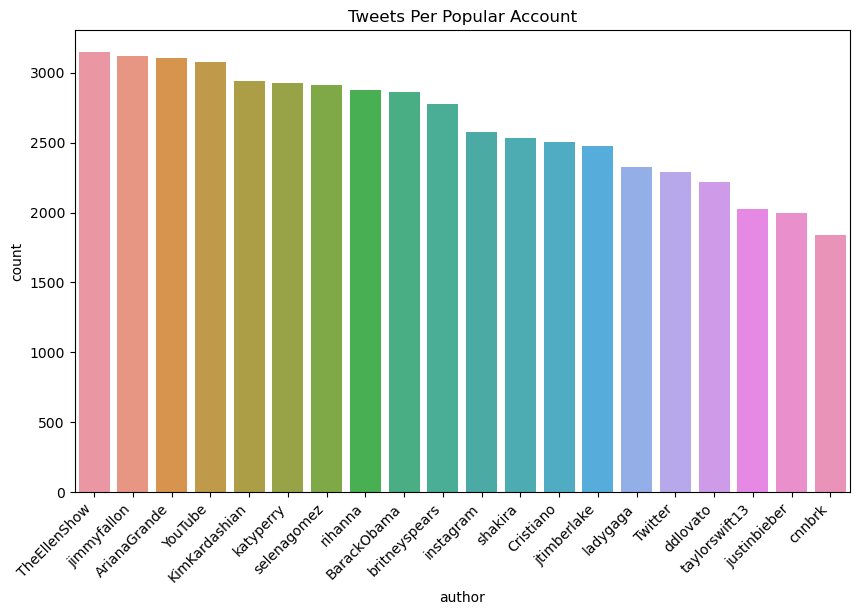

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x=df['author'], order = df['author'].value_counts().index, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Tweets Per Popular Account')
plt.show()

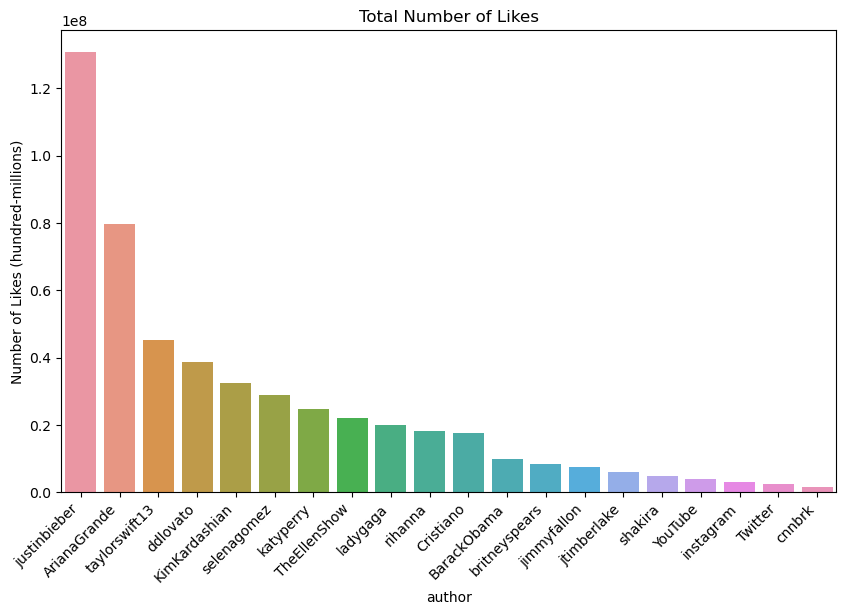

In [10]:
likes = df.groupby('author')['number_of_likes'].sum().sort_values(ascending=False)
likes = likes.reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=likes, x='author', y='number_of_likes', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Total Number of Likes')
ax.set_ylabel('Number of Likes (hundred-millions)')
plt.show()

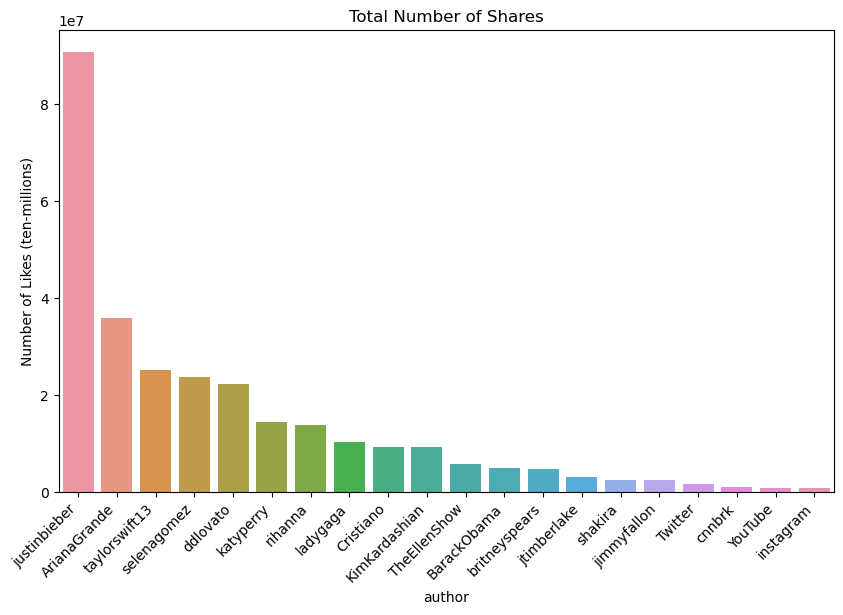

In [11]:
shares = df.groupby('author')['number_of_shares'].sum().sort_values(ascending=False)
shares = shares.reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=shares, x='author', y='number_of_shares', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Total Number of Shares')
ax.set_ylabel('Number of Likes (ten-millions)')
plt.show()

In [12]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [13]:
# Regex search patterns
urlregex = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userregex = '@[^\s]+'
alphanumericregex = "[^a-zA-Z0-9]"

In [14]:
tweets = list(df['content'])

def tweet_cleaner(tweets):
    cleaned = []
    
    for i in tweets:
        i = i.lower()
        i = re.sub(urlregex,' URL',i)
        for emoji in emojis.keys():
            i = i.replace(emoji, "EMOJI" + emojis[emoji])        
        i = re.sub(userregex,' USER', i)        
        i = re.sub(alphanumericregex, " ", i)

        words = ''
        for word in i.split():
            if word not in STOPWORDS:
                if word not in ('re', 've'):
                    words += (word+' ')
            
        cleaned.append(words)
        
    return cleaned

In [15]:
content = tweet_cleaner(tweets)

In [46]:
df['content_cleaned'] = content

In [28]:
sentiment_analysis = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
tweets_analyzed = []
for item in content:
     sentiment = sentiment_analysis(item)
     tweets_analyzed.append({'tweet': item, 'sentiment': sentiment[0]['label']})

In [44]:
# Saved to avoid rerunning the model.
analyzed_df = pd.DataFrame(tweets_analyzed)
df['sentiment'] = analyzed_df['sentiment']
df.to_csv('Analyzed_Tweets.csv')

In [47]:
final_df = pd.read_csv('Analyzed_Tweets.csv')
final_df = final_df.drop('Unnamed: 0', axis=1)
final_df.sample(15).head(15)

,author,content,number_of_likes,number_of_shares,content_cleaned,sentiment
24809,jtimberlake,Suit and tie #RockInRio #The2020Experience #2o...,2305,4358,suit tie rockinrio the2020experience 2of2 URL,NEU
5417,taylorswift13,Kissing my love at the @BRITAwards \r\nPart II...,41827,18241,kissing love USER part iii URL,NEU
18116,TheEllenShow,"You may not have seen me the first time, but I...",14669,3455,may seen first time absolutely USER farewell a...,NEU
8259,BarackObama,Retweet if you believe it's time for action on...,3629,5796,retweet believe s time action climate change a...,NEU
17632,ladygaga,Exclusive @styledotcom #CheekToCheek interview...,3918,2526,exclusive USER cheektocheek interview candid a...,NEU
25066,jtimberlake,Congrats Lisa Mangoendirjo! http://t.co/y6OX9k...,233,252,congrats lisa mangoendirjo URL finderskeepers,POS
16893,ladygaga,Just doing a bit of monster homework Horrible ...,7221,5122,bit monster homework horrible lipstick acciden...,NEG
41783,jimmyfallon,A relative got me an aroma therapy kit when I ...,660,168,relative got aroma therapy kit college still d...,NEG
24163,jtimberlake,Thanks for everyone who has entered &amp; supp...,1452,2038,thanks everyone entered amp supported USER far...,POS
11449,rihanna,Lighter of the moment #outlaw #thuglife http:/...,968,1129,lighter moment outlaw thuglife URL,NEU


In [55]:
sentiment_count = final_df.groupby('sentiment')['sentiment'].count()
print(sentiment_count)

sentiment
NEG     3523
NEU    30580
POS    18439
Name: sentiment, dtype: int64


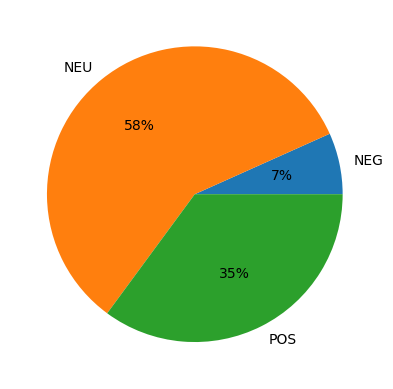

In [69]:
plt.pie(data=sentiment_count, x=sentiment_count, labels=sentiment_count.index, autopct='%.0f%%')
plt.show()

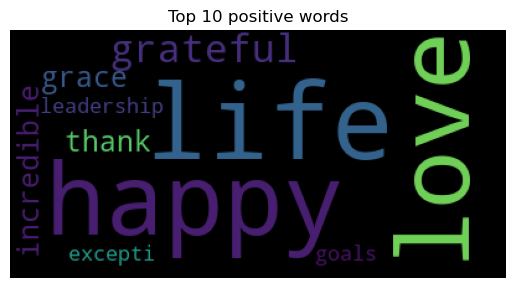

In [81]:
positive = df['content_cleaned'][df['sentiment'] == 'POS']
pos_wordcloud = WordCloud(max_words=10, stopwords=['USER', 'URL']).generate(str(positive))
plt.figure()
plt.title('Top 10 Positive Words')
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()

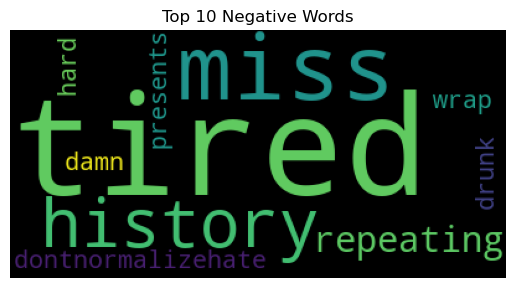

In [83]:
negative = df['content_cleaned'][df['sentiment'] == 'NEG']
neg_wordcloud = WordCloud(max_words=10, stopwords=['USER', 'URL', 's']).generate(str(negative))
plt.figure()
plt.title('Top 10 Negative Words')
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()